In [52]:

import numpy as np 
import matplotlib.pyplot as plt 
from scipy.stats import norm 
import statistics
from random import choices
from sklearn.neighbors import KernelDensity
from scipy.ndimage import gaussian_filter1d
from IPython.display import clear_output
import secrets


In [3]:
plt.style.use('/Users/lib278/Code/Python3/mpl_stylefiles/mystyle.mplstyle')

Bad value in file '/Users/lib278/Code/Python3/mpl_stylefiles/mystyle.mplstyle', line 17 ("mathtext.fallback: dejavsans  # Select fallback font from ['cm' (Computer Modern), 'stix'"): Key mathtext.fallback: dejavsans is not a valid fallback font name. Valid fallback font names are cm,stix,stixsans. Passing 'None' will turn fallback off.


In [4]:
def mode_pm_highest_density_interval(x, pdf_y, sigma, return_pdf=False):
    # 1sigma makes sigma = 0.6826

    step = 1e-6
    x_interp = np.arange(min(x), max(x) + step, step)
    pdf_y = np.interp(x=x_interp, xp=x, fp=pdf_y)
    x = x_interp

    cdf_y = np.cumsum(pdf_y)
    cdf_y = cdf_y / cdf_y[-1]  # Normalize the cdf so that it sums to 1.

    delta_xlist = []
    xlower = []
    xupper = []

    sigma_lower = 0
    delta = 1e-6

    for _ in range(0,round((1 - sigma)/delta)):
        x1 = np.interp(sigma_lower,cdf_y,x)
        xu = np.interp(sigma,cdf_y,x)
        delta_xlist.append(xu-x1)
        xlower.append(x1)
        xupper.append(xu)
        sigma += delta
        sigma_lower += delta

    index = delta_xlist.index(min(delta_xlist))
    mode = np.mean(x[pdf_y == max(pdf_y)]).round(1)
    mode = x[pdf_y == max(pdf_y)]
    if len(mode) > 1:
        mode = np.mean(mode)
    else:
        mode = mode[0]
    # print('The lower x value (for minimum credible interval) is ', xlower[index])
    # print('The upper x value (for minimum credible interval) is ', xupper[index])

    lower = mode - xlower[index]
    upper = xupper[index] - mode

    if return_pdf == True:
        return mode, lower, upper, x, pdf_y
    if return_pdf == False:
        return mode, lower, upper

def compute_kde(x_kde, y_kde, kde_n_draws, band_width):

    data_for_kde = choices(x, y_kde, k=kde_n_draws)
    data_for_kde = np.array(data_for_kde).reshape(-1, 1)

    # Compute the KDE
    reverse_x_grid = -x_kde[::-1][:-1]
    x_grid_wide = np.concatenate((reverse_x_grid, x))  # these must be arrays I think
    x_grid_wide_reshaped = np.array(x_grid_wide).reshape(-1, 1)

    kde = KernelDensity(kernel='gaussian', bandwidth=band_width).fit(data_for_kde)
    log_density = kde.score_samples(x_grid_wide_reshaped)
    uncorrected_density_estimation = np.array(np.exp(log_density))

    # Mirror the result about x=0
    uncorrected_density_estimation_mirrored = uncorrected_density_estimation[::-1]

    # Add the mirrored and non-mirrored KDEs
    corrected_density_estimation_wide = uncorrected_density_estimation + uncorrected_density_estimation_mirrored

    # Take only the values where x >= 0
    corrected_density_estimation = corrected_density_estimation_wide[x_grid_wide >= 0]

    # Renormalize
    corrected_density_estimation = corrected_density_estimation / (sum(corrected_density_estimation) * dx)

    return corrected_density_estimation



In [5]:
# # Plot between -10 and 10 with .001 steps. 
# dx = 0.01
# x = np.arange(15, 65, dx) 
  
# # Calculating mean and standard deviation 
# mean1 = 44
# sd1 = 4
# mean2 = 34
# sd2 = 7
# gauss1 = norm.pdf(x, mean1, sd1)
# gauss2 = norm.pdf(x, mean2, sd2)
# nominal_y = gauss1 + gauss2
# nominal_y = nominal_y / (sum(nominal_y) * dx)

# n_draws = 1000
# mean1_draws = np.random.normal(mean1, sd1, n_draws)
# mean2_draws = np.random.normal(mean2, sd2, n_draws)

# temp_ylist = []
# for draw in range(len(mean1_draws)):
#     temp_gauss1 = norm.pdf(x, mean1_draws[draw], sd1)
#     temp_gauss2 = norm.pdf(x, mean2_draws[draw], sd1)
#     temp_y = temp_gauss1 + temp_gauss2
#     temp_y = temp_y / (sum(temp_y) * dx)
#     temp_ylist.append(temp_y)

# temp_ytp = np.transpose(temp_ylist)

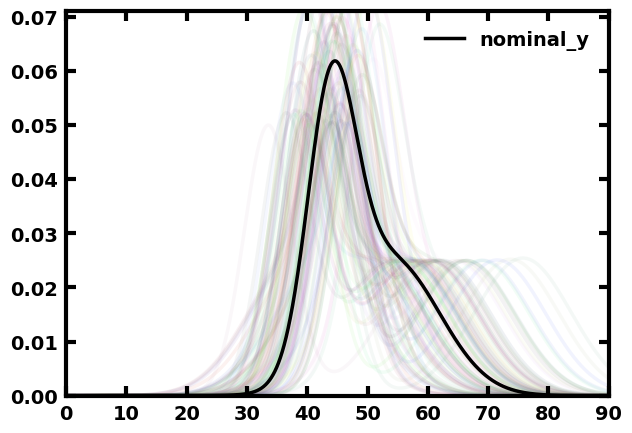

In [83]:
np.random.seed(42)

# Plot between -10 and 10 with .001 steps. 
dx = 0.01
x = np.arange(0, 90 + dx, dx) 
nominal_y = np.zeros_like(x)
  
# Generate lists of means and standard deviations
n_gaussians = 2
means = np.random.uniform(0, 64, n_gaussians)
stddevs = np.random.uniform(1, 8, n_gaussians)
means = [44, 54]
stddevs = [4, 8]

for gauss_i in range(n_gaussians):
    gauss_i = norm.pdf(x, means[gauss_i], stddevs[gauss_i])
    # plt.plot(x, gauss_i, alpha=0.5, zorder=-2)
    nominal_y = nominal_y + gauss_i

nominal_y = nominal_y / (sum(nominal_y) * dx)
# plt.plot(x, nominal_y, color='#000000', zorder=-1)
# plt.xlim(0, 90)
# plt.show()

n_draws = 1
n_iters = 100  # 250
mean_draws = []
temp_ylist = []

temp_y = np.zeros_like(x)

do_altered = 'False'

for iter_i in range(n_iters):
    print(str(np.round((iter_i+1)/n_iters * 100,2)) + r'%', end="\r")

    temp_y = np.zeros_like(x)
    
    for gauss_i in range(n_gaussians):
        nominal_gauss_i = norm.pdf(x, means[gauss_i], stddevs[gauss_i])

        mean_draw_i = np.random.normal(means[gauss_i], stddevs[gauss_i], 1)[0]
        flag = 1
        if mean_draw_i < 0 or mean_draw_i > 90:
            flag = 0
        while flag == 0:
            mean_draws_i = np.random.normal(means[gauss_i], stddevs[gauss_i], 1)[0]
            if mean_draw_i >= 0 or mean_draw_i <= 90:
                flag = 1

        temp_gauss_i = norm.pdf(x, mean_draw_i, stddevs[gauss_i])

        temp_y = temp_y + temp_gauss_i

    temp_y = temp_y / (sum(temp_y) * dx)

    std_color = "#" + secrets.token_hex(3)
    plt.plot(x, temp_y, color=std_color, alpha=0.06, zorder=-3)

    temp_ylist.append(temp_y)

    # plt.plot(x, temp_y, color='blue', label='unaltered', zorder=-1)

    temp_ytp = np.transpose(temp_ylist)

temp_ylist_mean = np.mean(temp_ylist, axis=0)
# temp_ylist_mean = temp_ylist_mean / (sum(temp_ylist_mean) * dx)

plt.plot(x, nominal_y, color='#000000', zorder=-2, label='nominal_y')
# plt.plot(x, temp_ylist_mean, color='darkviolet', zorder=-2, label='temp_ylist_mean')
plt.legend(loc='best')
plt.xlim(0, 90)
plt.ylim(0, 1.15*max(nominal_y))
plt.show()

In [96]:

percentile_16 = []
percentile_50 = []
percentile_84 = []


percentile_16 = np.percentile(temp_ylist, 16, axis=0)
percentile_50 = np.percentile(temp_ylist, 50, axis=0)
percentile_84 = np.percentile(temp_ylist, 84, axis=0)

# percentile_16 = percentile_16 / (sum(percentile_50) * dx)
# percentile_50 = percentile_50 / (sum(percentile_50) * dx)
# percentile_84 = percentile_84 / (sum(percentile_50) * dx)


sigma_smooth = 1.25*(1 / dx)
percentile_16 = gaussian_filter1d(percentile_16, sigma_smooth)
percentile_50 = gaussian_filter1d(percentile_50, sigma_smooth)
percentile_84 = gaussian_filter1d(percentile_84, sigma_smooth)


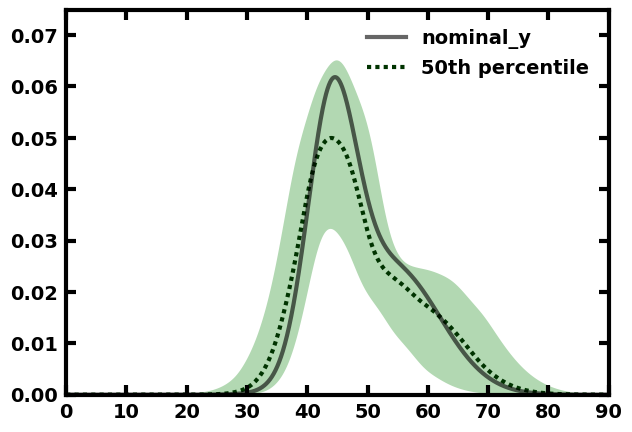

In [101]:
plt.plot(x, nominal_y, color='#000000', lw=3, alpha=0.6, label='nominal_y', zorder=-1) 
# plt.plot(x, percentile_16, color='green', lw=4, label='', zorder=-3)
plt.plot(x, percentile_50, color='#003300', lw=3, ls=':', dashes=(1,1), label='50th percentile', zorder=-2)
# plt.plot(x, percentile_84, color='green', lw=4, label='', zorder=-3)
plt.fill_between(x, percentile_84, percentile_16, lw=0, color='green', alpha=0.3, zorder=-4)
plt.xlim(0, 90)
plt.ylim(0, 1.15*max([max(percentile_84), max(nominal_y)]))
plt.legend(loc='best')
plt.show() 



In [94]:
mean_draws = []
stddev_draws = []

for temp_ytp_i in range(len(temp_ytp)):
    mean_draws.append(np.mean(temp_ytp[temp_ytp_i]))
    stddev_draws.append(np.std(temp_ytp[temp_ytp_i], ddof=1))

mean_draws = mean_draws / (sum(mean_draws) * dx)
stddev_draws = stddev_draws / (sum(mean_draws) * dx)


sigma_smooth = 1 / dx
mean_draws = gaussian_filter1d(mean_draws, sigma_smooth)
stddev_draws  = gaussian_filter1d(stddev_draws , sigma_smooth)
lower_draws = mean_draws - stddev_draws
upper_draws = mean_draws + stddev_draws

# x_lower = x[lower_draws > 0]
# lower_draws = lower_draws[lower_draws > 0]

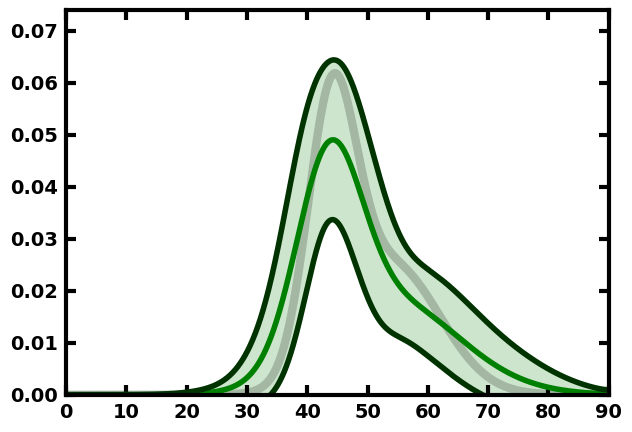

In [95]:
plt.plot(x, nominal_y, color='#000000', lw=6, alpha=0.2) 
plt.plot(x, mean_draws, color='green', lw=4)
plt.plot(x, lower_draws, color='#003300', lw=4)
plt.plot(x, upper_draws, color='#003300', lw=4)
plt.fill_between(x, upper_draws, lower_draws, color='green', alpha=0.2)
plt.xlim(min(x), max(x))
plt.ylim(0, 1.15*max(upper_draws))
plt.show() 

In [400]:
kde_n_draws = int(5e2)  # int(5e2)
band_width = 2.5  # np.median([sd1, sd2])

In [401]:
kde_nominal = compute_kde(x_kde=x, y_kde=nominal_y, kde_n_draws=kde_n_draws, band_width=band_width)

temp_kdelist = []
for temp_ylist_i in range(len(temp_ylist)):

    kde_temp = compute_kde(x_kde=x, y_kde=temp_ylist[temp_ylist_i], kde_n_draws=kde_n_draws, band_width=band_width)

    temp_kdelist.append(kde_temp)

In [402]:
print(np.shape(temp_kdelist))

(500, 200)


In [449]:
temp_kdetp = np.transpose(temp_kdelist)
kde_percentile_16 = []
kde_percentile_50 = []
kde_percentile_84 = []
for temp_kdetp_i in range(len(temp_kdetp)):
    kde_percentile_16.append(np.percentile(temp_kdetp[temp_kdetp_i], 16))
    kde_percentile_50.append(np.percentile(temp_kdetp[temp_kdetp_i], 50))
    kde_percentile_84.append(np.percentile(temp_kdetp[temp_kdetp_i], 84))

kde_percentile_16 = kde_percentile_16 / (sum(kde_percentile_50) * dx)
kde_percentile_50 = kde_percentile_50 / (sum(kde_percentile_50) * dx)
kde_percentile_84 = kde_percentile_84 / (sum(kde_percentile_50) * dx)

sigma_smooth = 4 * dx
kde_percentile_50 = gaussian_filter1d(kde_percentile_50, sigma_smooth)
kde_percentile_16 = gaussian_filter1d(kde_percentile_16, sigma_smooth)
kde_percentile_84 = gaussian_filter1d(kde_percentile_84, sigma_smooth)


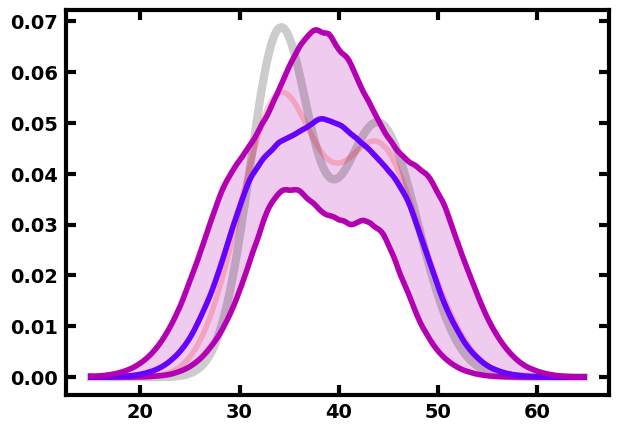

In [450]:
plt.plot(x, nominal_y, color='#000000', lw=6, alpha=0.2) 
plt.plot(x, kde_nominal, color='red', lw=4, alpha=0.2)
plt.plot(x, kde_percentile_16, color='#b300b3', lw=4)
plt.plot(x, kde_percentile_50, color='#6600ff', lw=4)
plt.plot(x, kde_percentile_84, color='#b300b3', lw=4)
plt.fill_between(x, kde_percentile_84, kde_percentile_16, color='#b300b3', alpha=0.2)

plt.show() 

200
dx_boop:  0.003
smooth_over_boop:  0.9
0.0 0.020162722892435207 0.0


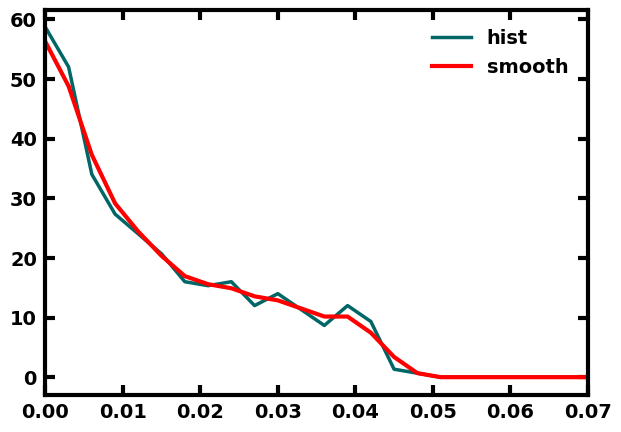

In [420]:
# temp_kdetp_i = 145  #  int(len(temp_kdetp)/2)
# print(len(temp_kdetp))

# max_range = 0.07
# diffs = np.diff(np.sort(temp_kdetp[temp_kdetp_i]))
# dx_boop = np.mean(diffs)
# dx_boop = 1.5 / kde_n_draws
# print('dx_boop: ', dx_boop)
# boop_x = np.arange(0, max_range + dx_boop, dx_boop)
# boop_x_bins = np.concatenate((boop_x, np.array([boop_x[-1] + dx_boop])))

# boop_hist, _ = np.histogram(temp_kdetp[temp_kdetp_i], bins=boop_x_bins)  # , density=True)

# smooth_over_boop = 0.9
# print('smooth_over_boop: ', smooth_over_boop)
# boop_smooth = gaussian_filter1d(boop_hist, smooth_over_boop)
# boop_smooth = boop_smooth / (sum(boop_smooth) * dx_boop)

# boop = boop_hist
# boop = boop / (sum(boop) * dx_boop)

# boop_mode, boop_lo, boop_hi = mode_pm_highest_density_interval(x=boop_x, pdf_y=boop_smooth, sigma=0.6826, return_pdf=False)

# # print('{:.2e} +{:.2e} -{:.2e}'.format(boop_mode, boop_hi, boop_lo))
# print(boop_mode, boop_hi, boop_lo)
# plt.plot(boop_x, boop, label='hist')
# plt.plot(boop_x, boop_smooth, color='red', lw=3, label='smooth')
# plt.xlim(0,0.07)
# plt.legend(loc='best')
# plt.show()


In [417]:
# kde_lo = []
# kde_mode = []
# kde_hi = []
# for temp_kdetp_i in range(len(temp_kdetp)):
#     # clear_output(wait=True)
#     # print('{:.2f}%'.format(((temp_kdetp_i + 1)/len(temp_kdetp))*100))
#     max_range = 0.07
#     dx_boop = 1.5 / kde_n_draws
#     boop_x = np.arange(0, max_range + dx_boop, dx_boop)
#     boop_x_bins = np.concatenate((boop_x, np.array([boop_x[-1] + dx_boop])))

#     boop_hist, _ = np.histogram(temp_kdetp[temp_kdetp_i], bins=boop_x_bins)

#     smooth_over_boop = 0.9
#     boop_smooth = gaussian_filter1d(boop_hist, smooth_over_boop)
#     boop_smooth = boop_smooth / (sum(boop_smooth) * dx_boop)

#     boop_mode, boop_lo, boop_hi = mode_pm_highest_density_interval(x=boop_x, pdf_y=boop_smooth, sigma=0.6826, return_pdf=False)

#     print('{:.2f}%\t{:.4f} +{:.4f} -{:.4f}'.format(((temp_kdetp_i + 1)/len(temp_kdetp))*100, boop_mode, boop_hi, boop_lo))

#     kde_lo.append(boop_mode - boop_lo)
#     kde_mode.append(boop_mode)
#     kde_hi.append(boop_mode + boop_hi)


0.50%	0.0000 +0.0027 -0.0000
1.00%	0.0000 +0.0027 -0.0000
1.50%	0.0000 +0.0027 -0.0000
2.00%	0.0000 +0.0027 -0.0000


KeyboardInterrupt: 

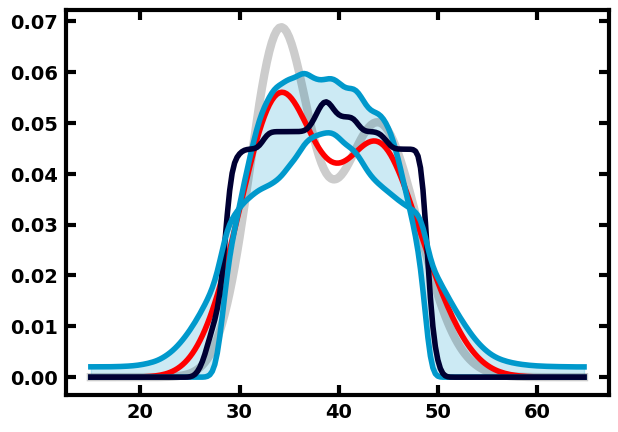

In [ ]:
# smooth_over_kde = 2
# kde_lo_smooth = gaussian_filter1d(kde_lo, smooth_over_kde)
# kde_lo_smooth = kde_lo_smooth / (sum(kde_lo_smooth) * dx)
# kde_mode_smooth = gaussian_filter1d(kde_mode, smooth_over_kde)
# kde_mode_smooth = kde_mode_smooth / (sum(kde_mode_smooth) * dx)
# kde_hi_smooth = gaussian_filter1d(kde_hi, smooth_over_kde)
# kde_hi_smooth = kde_hi_smooth / (sum(kde_hi_smooth) * dx)

# plt.plot(x, nominal_y, color='#000000', lw=6, alpha=0.2) 
# plt.plot(x, kde_nominal, color='red', lw=4)
# plt.plot(x, kde_lo_smooth, color='#0099cc', lw=4)
# plt.plot(x, kde_mode_smooth, color='#000033', lw=4)
# plt.plot(x, kde_hi_smooth, color='#0099cc', lw=4)
# plt.fill_between(x, kde_hi_smooth, kde_lo_smooth, color='#0099cc', alpha=0.2)